In [2]:
import json
import math
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from Bio import SeqIO
from augur.utils import json_to_tree
from scipy import stats

## Figure 5: mutations in the receptor-binding region of SARS-CoV-2 are accumulating much faster than in other endemic viruses

Plot the accumulation of mutations in the receptor-binding protein for SARS2 over time, for Omicron-only and for all 10 other viruses that evolve antigenically 

In [3]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [4]:
#read in colors from the manuscript_colors config file
color_config_json = f'config/manuscript_colors.json'
with open(color_config_json) as json_handle:
    colors = json.load(json_handle)

In [5]:
#path to the tree json files
tree_paths = {'sars2': '../sars2/auspice/ncov_gisaid_global_all-time.json', 
              'sars2_21L': '../sars2_21L/auspice/ncov_gisaid_21L_global_all-time.json', 
              'h3n2': "../seasonal-flu/auspice/flu_seasonal_h3n2_ha_60y.json", 
              'h1n1pdm': "../seasonal-flu/auspice/flu_seasonal_h1n1pdm_ha_12y.json", 
              'vic': "../seasonal-flu/new_builds/auspice/flu_seasonal_vic_ha_60y.json", 
              'yam': "../seasonal-flu/auspice/flu_seasonal_yam_ha_60y.json", 
              '229e': "../seasonal-covs/229e/auspice/229e_S1.json", 
              'oc43_A': "../seasonal-covs/oc43/separate_lineages/auspice/seasonal_corona_oc43_a_s1.json", 
              'norovirus': "../norovirus/auspice/norovirus_GII.4_VP1.json", 
              'enterovirusd68': "../enterovirus_d68/genome/enterovirus_d68_genome.json", 
              'rsv_A': "../rsv/rsv_step3/auspice/rsv_A.json", 
              'rsv_B': "../rsv/rsv_step3/auspice/rsv_B.json"}


In [6]:
#name of RB protein
rb_protein = {'sars2':'S1', 'sars2_21L':'S1', 
              'h3n2': 'HA1', 'h1n1pdm': 'HA1', 
              'vic':'HA1', 'yam': 'HA1', 
              '229e': 'S1', 'oc43_A': 's1', 
              'norovirus': "VP1", 'enterovirusd68': "VP1", 
              'rsv_A': "G", 'rsv_B': "G"}

In [7]:
#length of RB protein
rb_length = {'sars2':671, 'sars2_21L':671,
             'h3n2': 328, 'h1n1pdm': 326, 'vic':346, 'yam': 346, 
             '229e': 544, 'oc43_A': 752, 
             'norovirus': 540, 'enterovirusd68': 308, 
             'rsv_A': 321, 'rsv_B': 319}

In [8]:
def count_mutation_accumulation_on_tips(virus):
    """
    For each tip in the tree, find the nonsynonymous mutations in the receptor-binding protein 
    that have accumulated between the root of the tree and the tip
    """
    
    tree_file = tree_paths[virus]
    rb = rb_protein[virus]
    
    #read in the tree
    with open(tree_file, 'r') as f:
        tree_json = json.load(f)

    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    #initiate dictionary to keep track of the date and number of accumulated mutations for each tip on the tree
    aa_muts_over_time = []
    
    #get date of the root
    root_date = tree.root.node_attrs['num_date']['value']
    
    for node in tree.find_clades(terminal=True):
        path = tree.get_path(node)
#         print(node.branch_attrs['mutations'])
#         14-685
        
        #count the number of amino acid mutations between root and tip
        #sars2 S1 is not labeled, instead will get S1 mutations from spike mutations (S1 is spike AAs 14-685)
        if virus in ['sars2', 'sars2_21L']:
            muts_in_spike = [x.branch_attrs['mutations']['S'] for x in path if 'S' in x.branch_attrs['mutations'].keys()]            
            muts_in_s1 = [[y for y in x if 14<=int(y[1:-1])<=685] for x in muts_in_spike]
            muts_in_s1_no_deletions = [[y for y in x if '-' not in y] for x in muts_in_s1]
            count_muts_in_s1 = sum([len(x) for x in muts_in_s1])
            count_muts_in_s1_no_deletions = sum([len(x) for x in muts_in_s1_no_deletions])
            muts_on_path = count_muts_in_s1_no_deletions
        else:
            muts_in_rb = sum([len(x.branch_attrs['mutations'][rb]) for x in path if rb in x.branch_attrs['mutations'].keys()])
            muts_in_rb_no_deletions = sum([len([y for y in x.branch_attrs['mutations'][rb] if '-' not in y]) for x in path if rb in x.branch_attrs['mutations'].keys()])
            muts_on_path = muts_in_rb_no_deletions
            
        muts_on_path_per_codon = muts_on_path/rb_length[virus]
        #get the date of this tip
        num_date = node.node_attrs['num_date']['value']
        #time between root and tip
        time = num_date - root_date
        
        aa_muts_over_time.append({'virus':virus, 'tip': node.name, 
                                  'date': num_date, 'time_from_root': time, 
                                  'aa_muts': muts_on_path, 'aa_muts_per_codon': muts_on_path_per_codon})
    
    df = pd.DataFrame(aa_muts_over_time)
    
    return df    
        

In [9]:
#legible virus names for plotting
virus_name_legible = {'sars2': 'SARS-CoV-2', 'sars2_21L': 'SARS-CoV-2, Omicron 21L',
                      'h3n2': 'A/H3N2', 'h1n1pdm': 'A/H1N1pdm', 'vic':'B/Vic', 'yam': 'B/Yam', 
                      '229e': 'CoV 229E', 'oc43_A': 'CoV OC43-A', 
                      'norovirus': 'Norovirus GII.4', 'enterovirusd68': 'Enterovirus D68', 
                      'rsv_A': 'RSV-A', 'rsv_B': 'RSV-B'}

In [10]:
#save virus data so plots will run faster
all_viruses = ['sars2', 'sars2_21L', 'h3n2', 'h1n1pdm', 'vic', 'yam', 
               '229e', 'oc43_A', 'enterovirusd68', 'norovirus',
               'rsv_A', 'rsv_B']

virus_data = {}
for virus in all_viruses:
    df = count_mutation_accumulation_on_tips(virus)
    virus_data[virus] = df


In [11]:
def plot_mut_accumulation_vs_time(viruses, filename=None):
    """
    For each virus, plot every tip as the number of accumulated mutations vs. time since root
    """
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['figure.dpi']= 300
    
    fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), 
          (ax7,ax8,ax9), (ax10,ax11,ax12)) = plt.subplots(4,3, sharex=False, sharey=False, figsize=(18,12), 
                                                          gridspec_kw={'height_ratios': [2, 1, 1, 1]})
    
    fig_labels = ['A','B','C','D','E','F','G','H','I','J','K','L']
    
    for i in range(len(viruses)):
        virus = viruses[i]
        ax_i = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12][i]
        
        df = virus_data[virus]
        #markersize depending on number of points to plot, to make things more visible
        ms=18
        if len(df)>2000:
            ms = 12
        #plot the mutation accumulation over time
        ax_i.scatter(df['date'], df['aa_muts_per_codon'], color=colors['colors'][virus], 
                     marker='o', alpha=0.4, s=ms, zorder=1)

        #get linear fit
        coef = np.polyfit(df['date'], df['aa_muts_per_codon'], 1)
        poly1d_fn = np.poly1d(coef)

        #plot the linear regression line
        ax_i.plot(df['date'], poly1d_fn(df['date']), '-', linewidth=2, color='#474747', zorder=2)
        
        slope = coef[0]
        slope_readable = f'{round(slope*10**3, 1)}'+'$ × 10^{-3}$ subs/res/year'
        
        #label the virus, the rb-gene name, and the rate
        if i in [0,1,2]:
            ax_i.text(0.02, 0.98, virus_name_legible[virus], fontsize=20, horizontalalignment='left', 
                   verticalalignment='center', transform=ax_i.transAxes)
            ax_i.text(0.02, 0.88, rb_protein[virus], fontsize=16, horizontalalignment='left', 
                   verticalalignment='center', transform=ax_i.transAxes)

            ax_i.text(0.02, 0.8, slope_readable, fontsize=14, horizontalalignment='left', 
                   verticalalignment='center', transform=ax_i.transAxes)
        else:
            ax_i.text(0.02, 0.96, virus_name_legible[virus], fontsize=20, horizontalalignment='left', 
                   verticalalignment='center', transform=ax_i.transAxes)
            ax_i.text(0.02, 0.78, rb_protein[virus].upper(), fontsize=16, horizontalalignment='left', 
                   verticalalignment='center', transform=ax_i.transAxes)

            ax_i.text(0.02, 0.66, slope_readable, fontsize=14, horizontalalignment='left', 
                   verticalalignment='center', transform=ax_i.transAxes)
        
        #label only outer y-axes:
        if i==0:
            ax_i.set_ylabel('AA subs per residue\n$(× 10^{-3})$', fontsize=14)
        else:
            ax_i.set_ylabel('')
        #label only bottom x-axes
        if i >=9:
            ax_i.set_xlabel('Date', fontsize=14)
        else:
            ax_i.set_xlabel('')
            
        #add figure panel labels
        ax_i.text(-0.15, 1.0, fig_labels[i], horizontalalignment='center', 
                       verticalalignment='center', weight='bold', fontsize=24, transform=ax_i.transAxes)

        
        #dynamically get the y-range by dividing x range (in years) by 45
        x_range = df['date'].max()-df['date'].min()
        if i in [0,1,2]:
            ax_i.set_ylim([-0.1*(30/1000), x_range*(30/1000)])
        #these plots are half as tall
        else:
            ax_i.set_ylim([-0.1*(30/1000), x_range*(30/1000)*0.5])
        
        #make the sars2 x-axes less crowded
        if virus=='sars2':
            ax_i.set_xticks([2020, 2021, 2022, 2023])
            ax_i.set_xticklabels([2020, 2021, 2022, 2023])
        if virus=='sars2_21L':
            ax_i.set_xticks([2022, 2023])
            ax_i.set_xticklabels([2022, 2023])
            
    plt.subplots_adjust(hspace=0.3)
            
        
    sns.despine()
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    
        

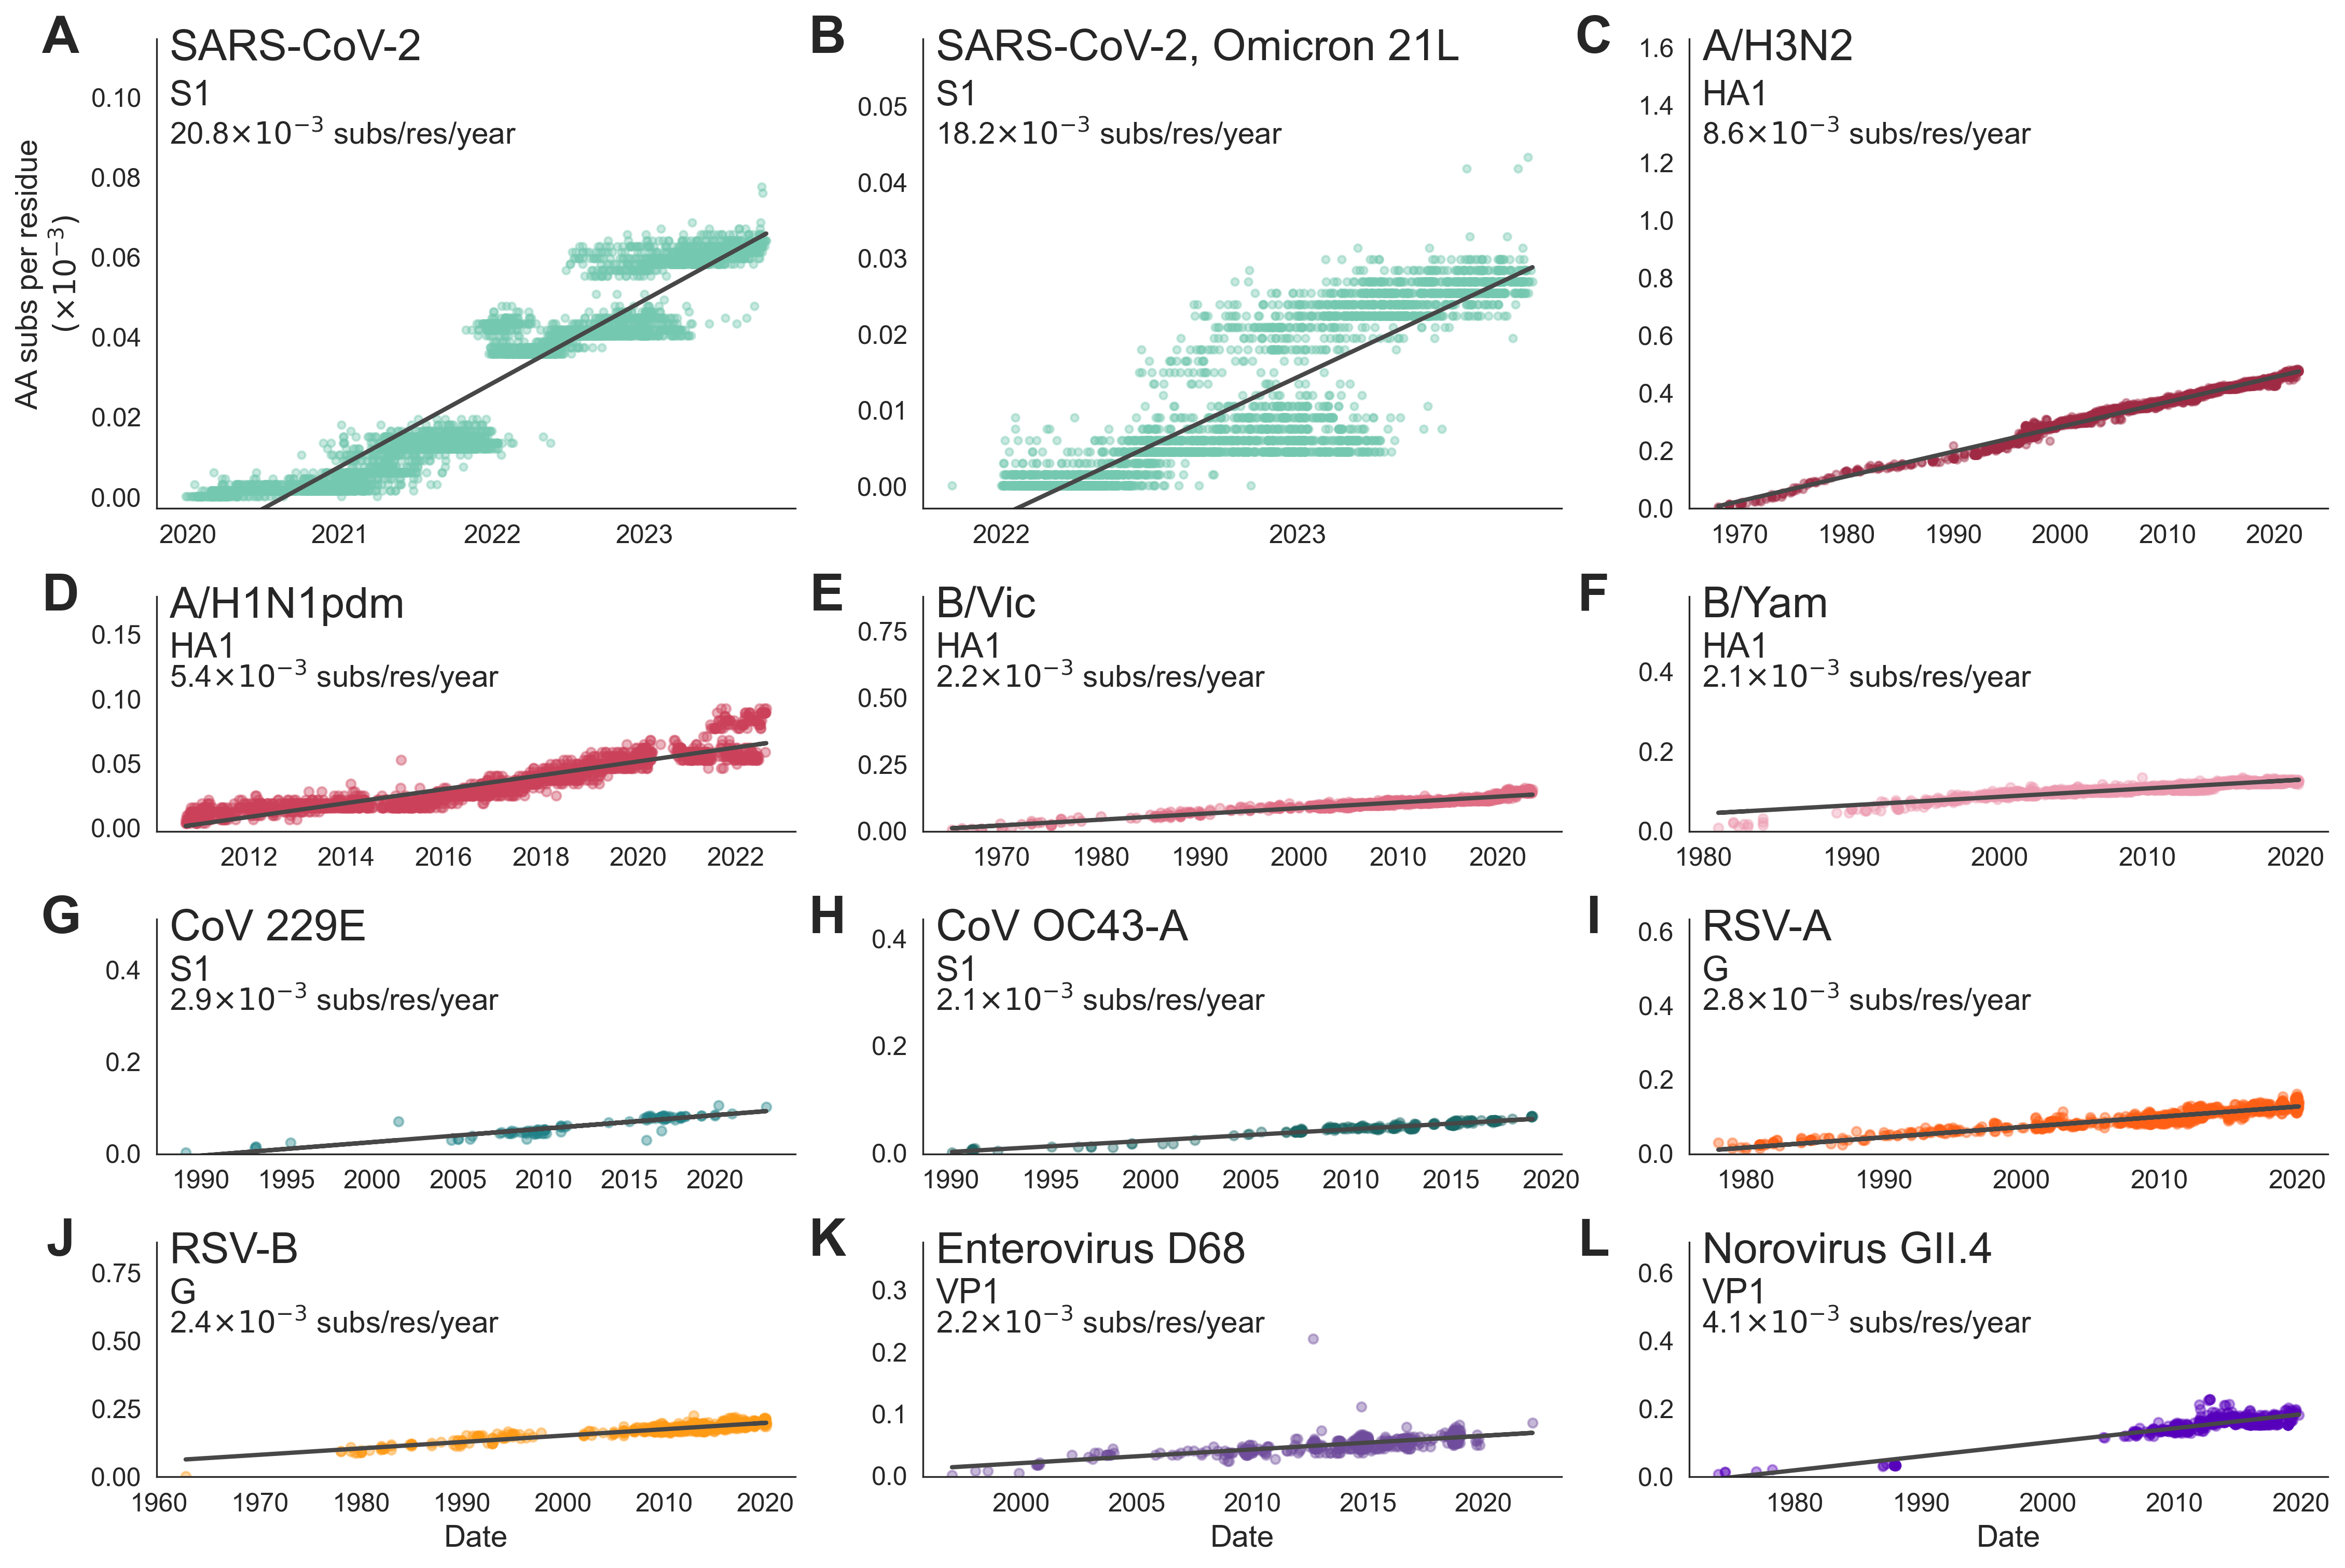

In [12]:
plot_mut_accumulation_vs_time(['sars2', 'sars2_21L', 
                               'h3n2', 'h1n1pdm', 'vic', 'yam', 
                               '229e', 'oc43_A', 'rsv_A', 'rsv_B', 
                               'enterovirusd68', 'norovirus'], filename = 'manuscript_figures/Figure5_SubRates.png')

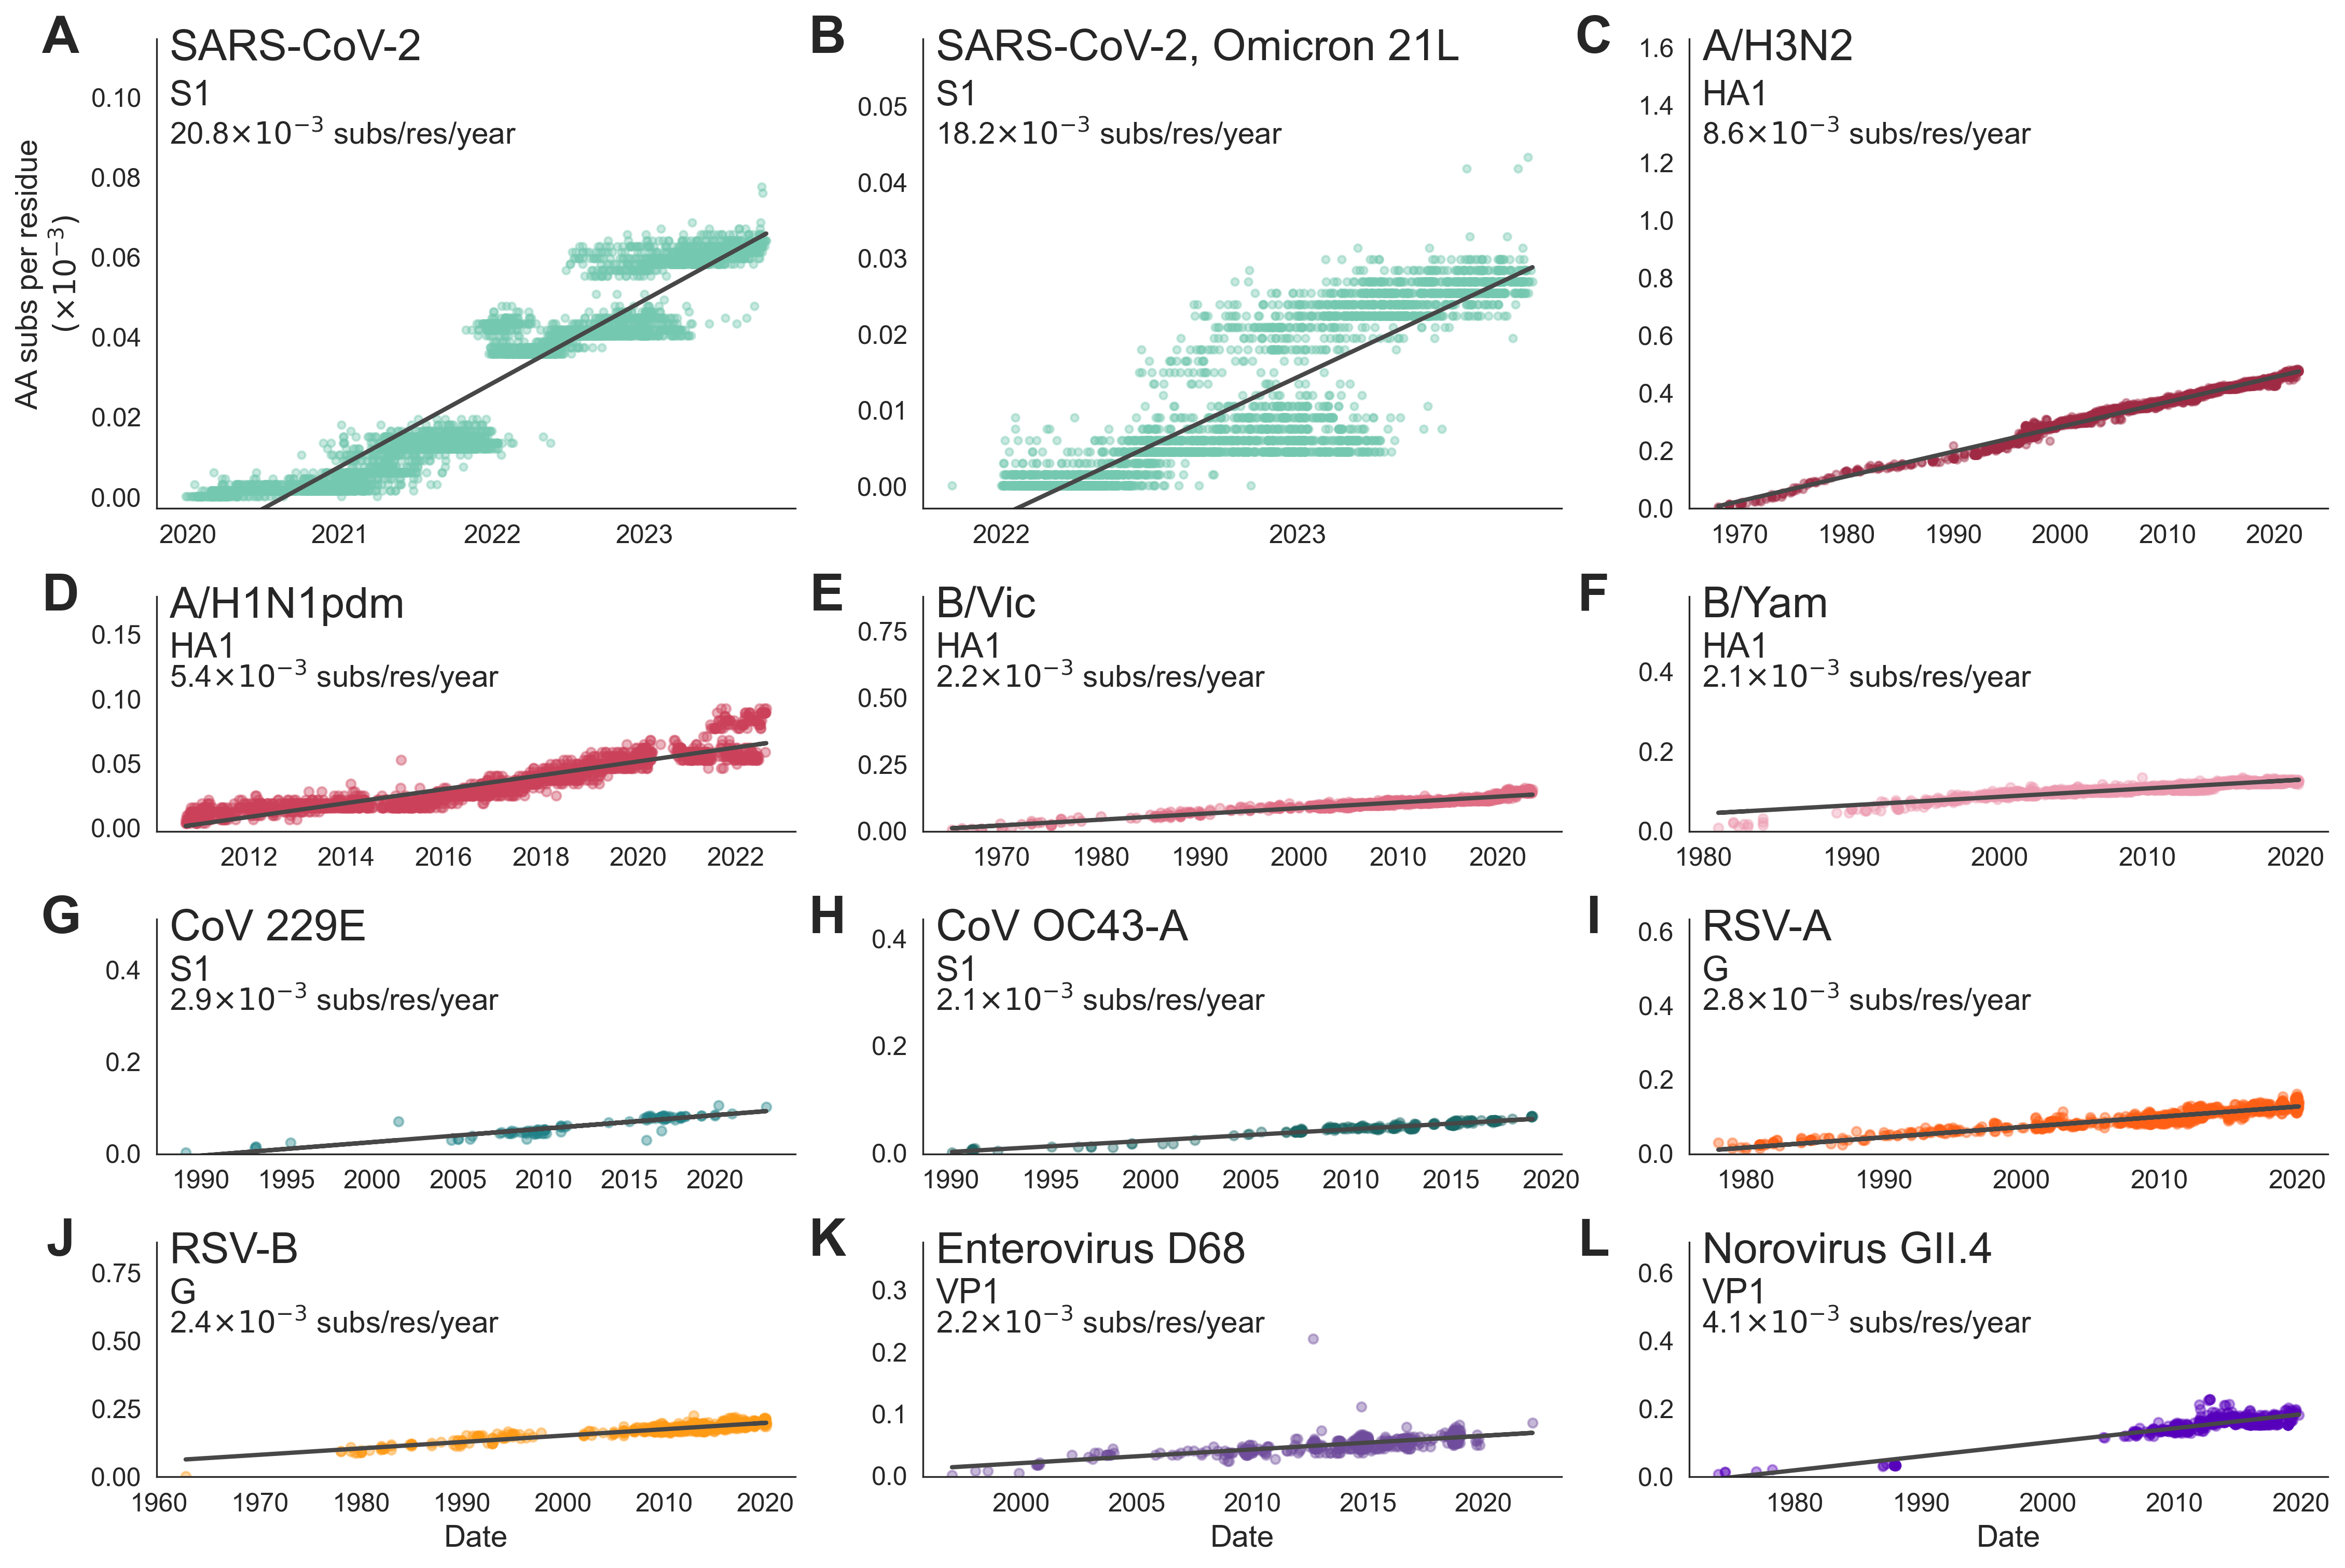

In [13]:
plot_mut_accumulation_vs_time(['sars2', 'sars2_21L', 
                               'h3n2', 'h1n1pdm', 'vic', 'yam', 
                               '229e', 'oc43_A', 'rsv_A', 'rsv_B', 
                               'enterovirusd68', 'norovirus'], filename = 'manuscript_figures/Figure5_SubRates.tiff')